In [1]:
import glob
import pandas as pd
import numpy as np
import os, sys
import collections
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_score


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier 

In [3]:
from numba.typed import List
from numba import jit, njit, vectorize

In [4]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [5]:
sample_rate = 50  # number of observation per second based on dataset documentation(150 samples in 3 second)

sliding_size = int((1/3) * sample_rate)  # number of skipped datapoints to start next window
print(sliding_size)

16


# Feature sets

In [6]:
@njit()
def mean_crossing_rate(col):
    # col = np.array(values)
    normalized = col - col.mean()  # to make elements of array possitive or negetive
    return ((normalized[:-1] * col[1:]) < 0).sum()  # Zero-Crossing_rate

@njit()
def iqr(window):  # inter-quartile range
    Q1 = np.median(window[:len(window)//2])  # First quartile (Q1) 
    Q3 = np.median(window[len(window)//2:])  # Third quartile (Q3) 
    IQR = Q3 - Q1 # Interquartile range (IQR) 
    return(IQR) 
@njit()
def calc_sma_for_window(data):
    return np.sum(data) / len(data)  
@njit()
def get_min(x):
    m = np.min(x)
    return m
@njit()
def get_max(x):
    m = np.max(x)
    return m
@njit()
def get_mean(x):
    m = np.mean(x)
    return m
@njit()
def get_var(x):
    m = np.var(x)
    return m
@njit()
def get_mean(x):
    m = np.mean(x)
    return m
@njit()
def get_sum(x):
    m = x.sum()
    return m 
@njit()
def get_median(x):
    m = np.median(x)
    return m 
@njit()
def get_std(x):
    m = np.median(x)
    return m 
@njit()
def get_rng(x):
    n = np.max(x)
    m = np.min(x)
    z = n-m
    return z 

def get_rms(x, axis=None):
    return np.sqrt(np.mean(x ** 2, axis=axis))

def calc_sma_for_window(data):
    return np.sum(data) / len(data)


def calc_sma_adv_for_window(data):
    return np.sum(data - np.mean(data) / len(data))


def calc_absolutes_for_list(list):
    return ([abs(i) for i in list])

def get_sma(data): 
    sma_sim = calc_sma_for_window(data)
    sma_adv = calc_sma_adv_for_window(data)

    sma_sim_abs = calc_sma_for_window(calc_absolutes_for_list(data))
    sma_adv_abs = calc_sma_adv_for_window(calc_absolutes_for_list(data))

    return sma_sim, sma_adv, sma_sim_abs, sma_adv_abs

def get_entropy(Y):
    """
    Also known as Shanon Entropy
    Reference: https://en.wikipedia.org/wiki/Entropy_(information_theory)
    """
    unique, count = np.unique(Y, return_counts=True, axis=0)
    prob = count/len(Y)
    en = np.sum((-1)*prob*np.log2(prob))
    return en

In [7]:
def Energy(frame):
    return sum( [ abs(x)**2 for x in frame ] ) / len(frame)

# Feature extraction and Z_score on signal

In [8]:
def Features(window):# mean, std,max,min and zero-crossing-rate
    wind = window.iloc[:, :-1]
    win = np.array(wind)
    
    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(win) # Z score normalization on signal
    win = scaled_X
    
    features = []
    
    features.append(get_mean(win))
    features.append(get_median(win))
    features.append(get_std(win))
    features.append(get_min(win))
    features.append(get_max(win))
    features.append(get_sum(win))
    features.append(get_entropy(win))
    mean_crossing = [mean_crossing_rate(win[:, i]) for i in range(win.shape[1])]
    features.append(np.array(mean_crossing))
    IQR = iqr(win)
    features.append(np.array(IQR))
    energy_measure = Energy(win)
    features.append(np.array(energy_measure))
 

    
    features = np.hstack(features).tolist()
    
    label = window.iloc[:, -1].mode()[0]  ## select the most frequent label as the label of the window
    features.append(label)
    return features

In [9]:
def windowing_dataset(dataset, win_size, feature_extraction_function, subject_id, overlap=False):
    windowed_dataset = []
    win_count = 0
    if overlap:
        step_size = sliding_size  # for Overlapping technique
    else:
        step_size = win_size  # for Non-overlapping technique

    for index in range(0, dataset.shape[0], step_size):
        start = index
        end = start + win_size
        # to assure all of windows are equal in size
        if (end <= dataset.shape[0]):
            window = dataset.iloc[start:end, :].reset_index(drop=True)
            win_count = win_count + 1
            features = feature_extraction_function(window)

            windowed_dataset.append(features)

    final = pd.DataFrame(windowed_dataset)
    final.insert(0, 'group', subject_id)  # to use in Subject CV
    return final

In [10]:
def Preprocessing(dataset_path, overlapping):
    feature_function = Features
    win_size = 3

    print("Start for win size {}".format(win_size))
    datapoints_per_window = int(win_size * sample_rate)

    print(feature_function.__name__)

    ACC = []
    GYR = []
    MAG = []
    QUAD = []

    for subject in range(1,18):
        file_path = dataset_path + '\subject{0}_ideal.csv'.format(subject)
        acc_cols = []
        gyr_cols = []
        mag_cols = []
        quad_cols = []
        
#########################################################################################################################
        for i in range(2, 117, 13):# indices of accelarations
            indices = list(range(i, i + 3))
            acc_cols.extend(indices)

        acc_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=acc_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        ACC.append(transformed_db)
#########################################################################################################################
        for i in range(5, 117, 13):# indices of gyr
            indices = list(range(i, i + 3))
            gyr_cols.extend(indices)

        gyr_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=gyr_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        GYR.append(transformed_db)
#########################################################################################################################        
        for i in range(8, 117, 13):# indices of mag
            indices = list(range(i, i + 3))
            mag_cols.extend(indices)

        mag_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=mag_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        MAG.append(transformed_db)
#########################################################################################################################
        for i in range(11, 117, 13):# indices of quad
            indices = list(range(i, i + 4))
            quad_cols.extend(indices)

        quad_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=quad_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        QUAD.append(transformed_db)
#########################################################################################################################
    #final_dataset = pd.DataFrame()
    ACC_dataset = pd.DataFrame()
    GYR_dataset = pd.DataFrame()
    MAG_dataset = pd.DataFrame()
    QUAD_dataset= pd.DataFrame()
    ACC_dataset = ACC_dataset.append(ACC, ignore_index=True)
    GYR_dataset = GYR_dataset.append(GYR, ignore_index=True)
    MAG_dataset = MAG_dataset.append(MAG, ignore_index=True)
    QUAD_dataset = QUAD_dataset.append(QUAD, ignore_index=True)
    return ACC_dataset,GYR_dataset,MAG_dataset,QUAD_dataset
   

In [11]:
def subject_cross_validation(X, Y, groups, classifier):
    f1 = []
    logo = LeaveOneGroupOut()
    i = 0
    for train_index, test_index in logo.split(X, Y, groups=groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        i += 1
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_test)
        f = f1_score(y_true=y_test, y_pred=y_pred, average='micro')
        
        print('Model-',i ,' -',' f1 score: ', f)
       
        f1.append(f)
    return np.mean(f1)

In [12]:
def classifier(dataset, model):
    results = dict()
    win_size = float(3)
    print('window_size = ', win_size,' sec')

    dataset = dataset
    groups = dataset['group']
    X = dataset.iloc[:, 1:-1]
    X = np.array(X)
    
    Y = dataset.iloc[:, -1]
    Y = np.array(Y)

    for model_name, mod in model.items():
        f1 = 0

        f1 = subject_cross_validation(X, Y, groups, mod)

        if win_size in results:
            results[win_size].append(f1)
        else:
            results[win_size] = [f1]


        results = collections.OrderedDict(sorted(results.items()))

        final = []
        col = list(model.keys())
        col.insert(0, "window-size")
        final.append(col)
        for k, v in results.items():
            tmp = []
            tmp.append([k])
            tmp.append(v)
            flattened = [val for sublist in tmp for val in sublist]
            final.append(flattened)

    accuracy = final[1][1]
    
    return accuracy

In [13]:
mod = {'RF': RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)}

In [14]:
dataset_csv_path = r"D:\projec\proj\data"

overlapping = 1  # input 0 for non overlapping, 1 for overlapping

ACC, GYR,MAG,QUAD = Preprocessing(dataset_path=dataset_csv_path, overlapping=bool(int(overlapping)))

Start for win size 3
Features


In [15]:
ACC.head(10)

,group,0,1,2,3,4,5,6,7,8,...,53,54,55,56,57,58,59,60,61,62
0,1,-2.040343e-16,0.001566,0.001566,-3.438411,6.538161,-8.263390e-13,7.228819,42.0,45.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
1,1,-4.031240e-17,-0.007960,-0.007960,-3.476881,6.182752,-1.632652e-13,7.228819,48.0,45.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2,1,1.026065e-16,-0.015050,-0.015050,-3.191164,5.336137,4.155565e-13,7.228819,50.0,33.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
3,1,1.475911e-16,0.059341,0.059341,-4.579770,5.177202,5.977441e-13,7.228819,28.0,35.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
4,1,1.395866e-16,0.091479,0.091479,-3.397207,5.569644,5.653256e-13,7.228819,15.0,25.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
5,1,2.563656e-16,0.085135,0.085135,-4.634725,5.399399,1.038281e-12,7.228819,5.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
6,1,-1.280457e-16,0.058519,0.058519,-4.941288,5.903783,-5.185852e-13,7.228819,3.0,31.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
7,1,8.982869e-17,0.036612,0.036612,-6.196391,7.110107,3.638062e-13,7.228819,5.0,33.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
8,1,1.141971e-16,0.041114,0.041114,-5.229891,7.135459,4.624981e-13,7.228819,1.0,21.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
9,1,-5.416792e-17,0.030282,0.030282,-5.148233,7.078129,-2.193801e-13,7.228819,1.0,16.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [16]:
GYR.head(10)

,group,0,1,2,3,4,5,6,7,8,...,53,54,55,56,57,58,59,60,61,62
0,1,1.422388e-17,0.033123,0.033123,-3.826598,4.082589,5.760670e-14,7.228819,23.0,9.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
1,1,3.289550e-18,0.030841,0.030841,-4.057517,3.763721,1.332268e-14,7.228819,30.0,10.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2,1,-5.153628e-18,0.043913,0.043913,-3.710378,3.824796,-2.087219e-14,7.228819,26.0,9.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
3,1,1.211651e-17,0.037344,0.037344,-5.112797,3.822966,4.907186e-14,7.228819,15.0,7.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
4,1,2.231411e-17,0.043371,0.043371,-4.371243,3.679249,9.037215e-14,7.228819,14.0,9.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
5,1,-8.909197e-18,0.044188,0.044188,-4.304808,4.836859,-3.608225e-14,7.228819,12.0,12.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
6,1,-1.154084e-17,0.042492,0.042492,-4.204104,5.410380,-4.674039e-14,7.228819,11.0,10.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
7,1,1.716048e-17,0.052338,0.052338,-4.615066,5.898383,6.949996e-14,7.228819,13.0,10.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
8,1,-1.348715e-17,0.046024,0.046024,-3.612855,4.764801,-5.462297e-14,7.228819,16.0,10.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
9,1,-1.041691e-17,0.037315,0.037315,-4.020031,4.781582,-4.218847e-14,7.228819,16.0,10.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [17]:
MAG.head(10)

,group,0,1,2,3,4,5,6,7,8,...,53,54,55,56,57,58,59,60,61,62
0,1,-1.853113e-17,-0.041726,-0.041726,-2.640575,2.959766,-7.505108e-14,7.228819,5.0,5.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
1,1,-4.281589e-16,-0.042108,-0.042108,-2.491908,2.919376,-1.734043e-12,7.228819,12.0,4.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2,1,-1.118118e-15,-0.065476,-0.065476,-2.390283,3.625384,-4.528378e-12,7.228819,12.0,6.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
3,1,4.872920e-16,-0.068585,-0.068585,-7.787038,6.498192,1.973532e-12,7.228819,5.0,9.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
4,1,-1.425472e-17,-0.036143,-0.036143,-4.080389,3.917901,-5.773160e-14,7.228819,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
5,1,2.625335e-16,-0.096668,-0.096668,-4.394271,4.249648,1.063261e-12,7.228819,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
6,1,-1.183278e-16,0.023762,0.023762,-3.289992,2.820009,-4.792278e-13,7.228819,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
7,1,5.291241e-16,0.014845,0.014845,-4.768571,6.354245,2.142952e-12,7.228819,1.0,13.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
8,1,-7.989220e-16,-0.051871,-0.051871,-3.439791,2.919661,-3.235634e-12,7.228819,1.0,4.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
9,1,2.631092e-16,0.014850,0.014850,-2.735248,2.375974,1.065592e-12,7.228819,1.0,3.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [18]:
QUAD.head(10)

,group,0,1,2,3,4,5,6,7,8,...,71,72,73,74,75,76,77,78,79,80
0,1,1.418248e-15,-0.007827,-0.007827,-3.344929,3.586185,7.658540e-12,7.228819,8.0,14.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
1,1,-4.601643e-16,0.008097,0.008097,-2.912811,2.729315,-2.484887e-12,7.228819,4.0,7.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2,1,1.348715e-16,0.028879,0.028879,-3.788830,3.329241,7.283063e-13,7.228819,4.0,5.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
3,1,1.554312e-16,0.007920,0.007920,-5.379982,5.885462,8.393286e-13,7.228819,3.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
4,1,4.592623e-16,0.095715,0.095715,-4.479869,3.835754,2.480016e-12,7.228819,1.0,3.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
5,1,-1.804318e-16,0.102951,0.102951,-4.194602,2.849328,-9.743317e-13,7.228819,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
6,1,-7.019796e-16,0.075406,0.075406,-3.015052,2.335644,-3.790690e-12,7.228819,1.0,3.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
7,1,-2.826957e-16,0.116711,0.116711,-6.654583,4.188572,-1.526557e-12,7.228819,1.0,3.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
8,1,-8.145747e-17,0.025767,0.025767,-2.976798,2.963765,-4.398704e-13,7.228819,1.0,4.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
9,1,-5.366078e-17,-0.053297,-0.053297,-2.676452,2.659060,-2.897682e-13,7.228819,1.0,6.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [19]:
print('ACC_accuracy = ', )
ACC_accuracy = classifier(dataset=ACC, model=mod)
ACC_accuracy 

ACC_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.8412587412587412
Model- 2  -  f1 score:  0.9076489249206908
Model- 3  -  f1 score:  0.8652
Model- 4  -  f1 score:  0.8926112895823772
Model- 5  -  f1 score:  0.7758620689655173
Model- 6  -  f1 score:  0.8388888888888889
Model- 7  -  f1 score:  0.7673130193905818
Model- 8  -  f1 score:  0.8149001536098309
Model- 9  -  f1 score:  0.8994871794871795
Model- 10  -  f1 score:  0.8880163878456812
Model- 11  -  f1 score:  0.8984375
Model- 12  -  f1 score:  0.8533291457286433
Model- 13  -  f1 score:  0.8156929156082416
Model- 14  -  f1 score:  0.8834917282646956
Model- 15  -  f1 score:  0.8479861411866608
Model- 16  -  f1 score:  0.7304601899196492
Model- 17  -  f1 score:  0.7767211867630277


0.8410179683188475

In [20]:
print('GYR_accuracy = ', )
GYR_accuracy = classifier(dataset=GYR, model=mod)
GYR_accuracy

GYR_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.7783216783216783
Model- 2  -  f1 score:  0.8219950652097285
Model- 3  -  f1 score:  0.7299999999999999
Model- 4  -  f1 score:  0.7930243230839835
Model- 5  -  f1 score:  0.7024137931034483
Model- 6  -  f1 score:  0.7877777777777778
Model- 7  -  f1 score:  0.9861495844875345
Model- 8  -  f1 score:  0.7676651305683564
Model- 9  -  f1 score:  0.778119658119658
Model- 10  -  f1 score:  0.8146124957323319
Model- 11  -  f1 score:  0.8321875
Model- 12  -  f1 score:  0.8329145728643216
Model- 13  -  f1 score:  0.6872706745695738
Model- 14  -  f1 score:  0.7933826117564238
Model- 15  -  f1 score:  0.7821567778258988
Model- 16  -  f1 score:  0.8064280496712929
Model- 17  -  f1 score:  0.7763408139977178


0.792397676887631

In [21]:
print('MAG_accuracy = ', )
MAG_accuracy = classifier(dataset=MAG, model=mod)
MAG_accuracy

MAG_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.5902097902097903
Model- 2  -  f1 score:  0.74656327106098
Model- 3  -  f1 score:  0.722
Model- 4  -  f1 score:  0.7356585589720055
Model- 5  -  f1 score:  0.5189655172413793
Model- 6  -  f1 score:  0.6955555555555556
Model- 7  -  f1 score:  0.739612188365651
Model- 8  -  f1 score:  0.7019969278033794
Model- 9  -  f1 score:  0.6488888888888888
Model- 10  -  f1 score:  0.7432570843291226
Model- 11  -  f1 score:  0.7353125
Model- 12  -  f1 score:  0.792713567839196
Model- 13  -  f1 score:  0.5825571549534293
Model- 14  -  f1 score:  0.7409362900387186
Model- 15  -  f1 score:  0.750974447812906
Model- 16  -  f1 score:  0.6157779401022644
Model- 17  -  f1 score:  0.6538607835678966


0.6891082627494803

In [22]:
print('QUAD_accuracy = ', )
QUAD_accuracy = classifier(dataset=QUAD, model=mod)
QUAD_accuracy

QUAD_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.5744755244755245
Model- 2  -  f1 score:  0.6313006697215369
Model- 3  -  f1 score:  0.6112
Model- 4  -  f1 score:  0.6636071592473611
Model- 5  -  f1 score:  0.4962068965517241
Model- 6  -  f1 score:  0.7222222222222222
Model- 7  -  f1 score:  0.7313019390581718
Model- 8  -  f1 score:  0.6559139784946236
Model- 9  -  f1 score:  0.602051282051282
Model- 10  -  f1 score:  0.7248207579378627
Model- 11  -  f1 score:  0.72125
Model- 12  -  f1 score:  0.7126256281407035
Model- 13  -  f1 score:  0.532317245272368
Model- 14  -  f1 score:  0.6670186554030271
Model- 15  -  f1 score:  0.6868774361195322
Model- 16  -  f1 score:  0.6351351351351351
Model- 17  -  f1 score:  0.6215290985165463


0.6464619781380954

In [23]:
d ={'ACC': [ACC_accuracy], 'GYR': [GYR_accuracy],'MAG': [MAG_accuracy],'QUAD': [QUAD_accuracy]}

In [24]:
df_accuracy = pd.DataFrame(data=d)

In [25]:
df_accuracy*100

,ACC,GYR,MAG,QUAD
0,84.101797,79.239768,68.910826,64.646198


In [26]:
df_accuracy 

,ACC,GYR,MAG,QUAD
0,0.841018,0.792398,0.689108,0.646462


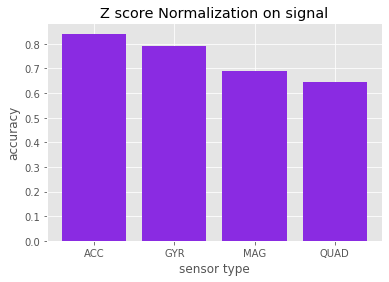

In [27]:
x = ['ACC', 'GYR', 'MAG', 'QUAD']
accuracy = [ACC_accuracy,GYR_accuracy,MAG_accuracy,QUAD_accuracy]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, accuracy, color='blueviolet')
plt.xlabel("sensor type")
plt.ylabel("accuracy")
plt.title("Z score Normalization on signal")

plt.xticks(x_pos, x)

plt.show()